[*********************100%***********************]  1 of 1 completed
                                 Close signal        min50        max50
2023-02-01 12:00:00+00:00  1580.458862      0  1570.530396  1584.298340
2023-02-01 13:00:00+00:00  1582.480469      0  1570.530396  1583.578125
2023-02-01 14:00:00+00:00  1585.606445      0  1570.530396  1585.606445
2023-02-01 15:00:00+00:00  1576.668823      0  1570.530396  1585.606445
2023-02-01 16:00:00+00:00  1574.908569      0  1570.530396  1585.606445
...                                ...    ...          ...          ...
2023-04-06 11:00:00+00:00  1868.761841      0  1861.387207  1899.986572
2023-04-06 12:00:00+00:00  1863.236572      0  1861.387207  1899.986572
2023-04-06 13:00:00+00:00  1865.933350      0  1861.387207  1892.977051
2023-04-06 14:00:00+00:00  1867.965942      0  1861.387207  1891.141968
2023-04-06 15:00:00+00:00  1875.292358      0  1861.387207  1891.141968

[1519 rows x 4 columns]
2023-02-01 19:00:00+00:00    1580.847046
2

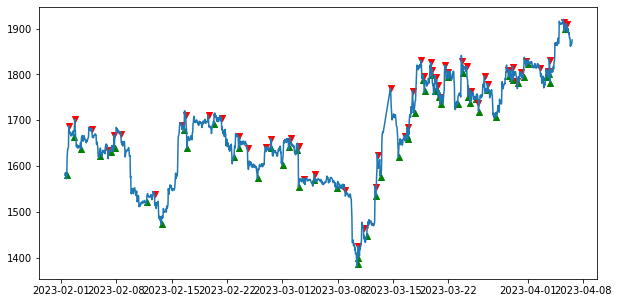

In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt


class Backtest:
    def __init__(self, symbol):
        self.symbol = symbol
        #    period=日期範圍 (1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max)
        #    interval=頻率 (1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo)

        self.df = yf.download(self.symbol, period = "1d",interval = "1h",start='2023-02-01',end='2023-4-07')
        if self.df.empty:
            print('No data pulled')
        else:
            self.calc_indicators()
            self.generate_signals()
            self.loop_it()
            self.profit=self.calc_profit()
            self.max_dd= self.profit.min()
            self.cumul_profit= (self.profit + 1).prod() - 1



    def calc_indicators(self):
        self.df['ma_20'] = self.df.Close.rolling(20).mean()
        self.df['vol'] = self.df.Close.rolling(20).std()
        self.df['min50'] = self.df.Close.rolling(10).min()
        self.df['max50'] = self.df.Close.rolling(10).max()

        self.df['upper_bb'] = self.df.ma_20 + (2 * self.df.vol)
        self.df['lower_bb'] = self.df.ma_20 - (2 * self.df.vol)
        self.df['rsi'] = ta.momentum.rsi(self.df.Close, window=6)
        self.df.dropna(inplace=True)

    def generate_signals(self):
        conditions = [(self.df.rsi < 30) & (self.df.Close < self.df.lower_bb),
                      (self.df.rsi > 70) & (self.df.Close > self.df.upper_bb)]
        conditions2= [(self.df.Close <= self.df.Close.shift(-1)-10),(self.df.Close >= self.df.Close.shift(-1)+10)]
        choices = ['L', 'S']
        #self.df['signal'] = np.select(conditions,choices)
        self.df['signal']=np.select(conditions2,choices)
        self.df.signal=self.df.signal.shift()
        self.df.dropna(inplace=True)

    def loop_it(self):
        position = False
        buydates,selldates=[],[]
        
        for index, row in self.df.iterrows():
            if not position and row['signal']== 'L':
                position=True
                buydates.append(index)
            if position and row['signal']=='S':
                position=False
                selldates.append(index)
        
        self.buy_arr=self.df.loc[buydates].Open
        self.sell_arr=self.df.loc[selldates].Open

    def calc_profit(self):
        if self.buy_arr.index[-1] > self.sell_arr.index[-1]:
            self.buy_arr=self.buy_arr[:-1]
        return (self.sell_arr.values - self.buy_arr.values)/self.buy_arr.values * 100

    def plot_chart(self):
        plt.figure(figsize=(10,5))
        plt.plot(self.df.Close)
        plt.scatter(self.buy_arr.index,self.buy_arr.values,marker='^', c='g')
        plt.scatter(self.sell_arr.index,self.sell_arr.values,marker='v', c='r')

    
instance = Backtest('ETH-USD')
pd.set_option('display.max_rows', 1500)


# print(instance.df[['Close', 'min50','min_signal','max50']])
print(instance.df[['Close',  'signal', 'min50','max50']])

print(instance.buy_arr)

print(instance.sell_arr)
      
print(instance.profit)

print(instance.cumul_profit)

instance.plot_chart()
